# Données spatiales : découverte de geopandas


Dans ce tutoriel, nous allons utiliser les données suivantes :

-   [Localisations des stations velib](https://opendata.paris.fr/explore/dataset/velib-emplacement-des-stations/download/?format=geojson&timezone=Europe/Berlin&lang=fr) ;
-   [fonds de carte `AdminExpress`](https://geoservices.ign.fr/adminexpress) à
    travers un package `Python` nommé [`cartiflette`](https://github.com/InseeFrLab/cartogether)
    facilitant la récupération de cette source.

Quelques méthodes
pour faire rapidement des cartes seront présentées ici, mais
l’objet de ce chapitre porte davantage sur la manipulation des données géographiques.


Quelques installations préalables sont nécessaires :

In [1]:
!pip install pandas fiona shapely pyproj rtree # à faire obligatoirement en premier pour utiliser rtree ou pygeos pour les jointures spatiales
!pip install contextily
!pip install geopandas
!pip install topojson

ERROR: Invalid requirement: '#'

[notice] A new release of pip is available: 23.0.1 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.0.1 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.0.1 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


     ---------------------------------------- 0.0/82.7 kB ? eta -:--:--
     -------------- ------------------------- 30.7/82.7 kB ? eta -:--:--
     ---------------------------------------- 82.7/82.7 kB 1.2 MB/s eta 0:00:00



[notice] A new release of pip is available: 23.0.1 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


Pour être en mesure d’exécuter ce tutoriel, les imports suivants
seront utiles.

In [2]:
import geopandas as gpd
import contextily as ctx
import matplotlib.pyplot as plt

## Données spatiales

### Quelle différence avec des données traditionnelles ?

**Le terme “données spatiales” désigne les données qui portent sur les caractéristiques géographiques des objets (localisation, contours, liens)**.
Les caractéristiques géographiques des objets sont décrites à l’aide d’un **système de coordonnées**
qui permettent une représentation dans un espace euclidien $(x,y)$.
Le passage de l’espace réel (la Terre, qui est une sphère) à l’espace plan
se fait grâce à un **système de projection**. Voici quelques exemples
de données spatiales :

-   Une table décrivant des bâtiments, avec les coordonnées géographiques de chaque bâtiment ;
-   Le découpage communal du territoire, avec le contour du territoire de chaque commune ;
-   Les routes terrestres, avec les coordonnées décrivant leur parcours en 3 dimensions (longitude, latitude, altitude).

Les données spatiales rassemblent classiquement deux types de données :

1.  des **données géographiques** (ou géométries) : objets géométriques tels que des points, des vecteurs, des polygones, ou des maillages (*raster*). Exemple: la forme de chaque commune, les coordonnées d’un bâtiment;
2.  des **données attributaires** (ou attributs) : des mesures et des caractéristiques associées aux objets géométriques. Exemple: la population de chaque commune, le nombre de fenêtres et le nombre d’étages d’un bâtiment.

**Les données spatiales sont fréquemment traitées à l’aide d’un système d’information géographique (SIG)**, c’est-à-dire un système d’information capable de stocker, d’organiser et de présenter des données alphanumériques spatialement référencées par des coordonnées dans un système de référence (CRS). `Python` dispose de fonctionnalités lui permettant de réaliser les mêmes tâches qu’un SIG (traitement de données spatiales, représentations cartographiques).

### De `Pandas` à `Geopandas`

Le *package* `Geopandas` est une boîte à outils conçue pour faciliter la manipulation de données spatiales. **La grande force de `Geopandas` est qu’il permet de manipuler des données spatiales comme s’il s’agissait de données traditionnelles**, car il repose sur le standard ISO 19125 [*simple feature access*](https://en.wikipedia.org/wiki/Simple_Features) défini conjointement par l’*Open Geospatial Consortium (OGC)* et l’*International Organization for Standardization (ISO)*.

Par rapport à un DataFrame standard, un objet `Geopandas` comporte
une colonne supplémentaire: `geometry`. Elle stocke les coordonnées des
objets géographiques (ou ensemble de coordonnées s’agissant de contours). Un objet `Geopandas` hérite des propriétés d’un
DataFrame `Pandas` mais propose des méthodes adaptées au traitement des données spatiales.

Ainsi, grâce à `Geopandas`, on pourra effectuer des manipulations sur les attributs des données comme avec `pandas` mais on pourra également faire des manipulations sur la dimension spatiale des données. En particulier,

-   Calculer des distances et des surfaces ;
-   Agréger rapidement des zonages (regrouper les communes en département par exemple) ;
-   Trouver dans quelle commune se trouve un bâtiment à partir de ses coordonnées géographiques ;
-   Recalculer des coordonnées dans un autre système de projection ;
-   Faire une carte, rapidement et simplement.

<div class="alert alert-warning" role="alert" style="color: rgba(0,0,0,.8); background-color: white; margin-top: 1em; margin-bottom: 1em; margin:1.5625emauto; padding:0 .6rem .8rem!important;overflow:hidden; page-break-inside:avoid; border-radius:.25rem; box-shadow:0 .2rem .5rem rgba(0,0,0,.05),0 0 .05rem rgba(0,0,0,.1); transition:color .25s,background-color .25s,border-color .25s ; border-right: 1px solid #dee2e6 ; border-top: 1px solid #dee2e6 ; border-bottom: 1px solid #dee2e6 ; border-left:.2rem solid #ffc10780;">
<h3 class="alert-heading"><i class="fa fa-lightbulb-o"></i> Hint</h3>

Les manipulations de données sur un objet `Geopandas` sont nettement plus lentes que sur
un `DataFrame` traditionnel (car `Python` doit gérer les informations géographiques pendant la manipulation des données).
Lorsque vous manipulez des données de grandes dimensions,
il peut être préférable d’effectuer les opérations sur les données avant de joindre une géométrie à celles-ci.

</div>

Par rapport à un logiciel spécialisé comme `QGIS`, `Python` permettra
d’automatiser le traitement et la représentation des données. D’ailleurs,
`QGIS` utilise lui-même `Python`…

### Résumé

En résumé, un objet `GeoPandas` comporte les éléments suivantes :

![](https://rgeo.linogaliana.fr/slides/img/sf.png)

1.  Les **attributs**. Ce sont les valeurs associées à chaque niveau géographique.
    Il s’agit de la dimension tabulaire usuelle, dont le traitement est similaire
    à celui d’un objet `Pandas` classique.
2.  Les **géométries**. Ce sont les valeurs numériques interprétées pour représenter la dimension géographique. Elles permettent de représenter dans un certain
    référentiel (le système de référence) la dimension géographique.
3.  Le **système de référence**. Il s’agit du système permettant de transformer les positions sur
    le globe (3 dimensions avec une boule asymétrique) en un plan en deux dimensions.
    Il en existe une multitude, identifiables à partir d’un code EPSG (4326, 2154…).
    Leur manipulation est facilitée par `Geopandas` qui s’appuie sur `Shapely`, de la même
    manière que `Pandas` s’appuie sur `Numpy` ou `Arrow`.

## Le système de projection cartographique

### Principe

Les données spatiales sont
plus riches que les données traditionnelles car elles
incluent, habituellement, des éléments supplémentaires pour placer dans
un espace cartésien les objets. Cette dimension supplémentaire peut être simple
(un point comporte deux informations supplémentaire: $x$ et $y$) ou
assez complexe (polygones, lignes avec direction, etc.).

L’analyse cartographique emprunte dès lors à la géométrie
des concepts
pour représenter des objets dans l’espace. Les **projections**
sont au coeur de la gestion des données spatiales.
Ces dernières consistent à transformer une position dans l’espace
terrestre à une position sur un plan. Il s’agit donc d’une opération
de projection d’un espace tri-dimensionnel dans un espace
à deux dimensions.
Ce [post](https://www.earthdatascience.org/courses/earth-analytics/spatial-data-r/geographic-vs-projected-coordinate-reference-systems-UTM/) propose de riches éléments sur le
sujet, notamment l’image suivante qui montre bien le principe d’une projection :

![Les différents types de projection](https://www.earthdatascience.org/images/courses/earth-analytics/spatial-data/spatial-projection-transformations-crs.png)

Cette opération n’est pas neutre. L’une des conséquences du
[théorème remarquable de Gauss](https://fr.wikipedia.org/wiki/Theorema_egregium)
est que la surface de la Terre ne peut être cartographiée sans distortion.
Une projection ne peut simultanément conserver intactes les distances et les
angles (i.e. les positions).
Il n’existe ainsi pas de projection universellement meilleure, ce qui ouvre
la porte à la coexistence de nombreuses projections différentes, pensées
pour des tâches différentes.
Un mauvais système de représentation
fausse l’appréciation visuelle mais peut aussi entraîner des erreurs dans
les calculs sur la dimension spatiale.

**Les systèmes de projection font l’objet de standards internationaux et sont souvent désignés par des codes dits codes EPSG**. Ce [site](https://epsg.io/) est un bon aide-mémoire. Les plus fréquents, pour les utilisateurs français, sont les suivants (plus d’infos [ici](https://geodesie.ign.fr/contenu/fichiers/documentation/SRCfrance.pdf)) :

-   `2154` : système de projection Lambert 93. Il s’agit du système de projection officiel. La plupart des données diffusées par l’administration pour la métropole sont disponibles dans ce système de projection.
-   `27572` : Lambert II étendu. Il s’agit de l’ancien système de projection officiel. Les données spatiales anciennes peuvent être dans ce format.
-   `4326` : WGS 84 ou système de pseudo-Mercator ou encore *Web Mercator*. Ce n’est en réalité pas un système de projection mais un système de coordonnées (longitude / latitude) qui permet simplement un repérage angulaire sur l’ellipsoïde. Il est utilisé pour les données GPS. Il s’agit du système le plus
    usuel, notamment quand on travaille avec des fonds de carte *web*.

Comme évoqué plus haut, l’une des projections les plus connues est la
projection *Web Mercator* dite WGS84 (code EPSG 4326). Il
s’agit d’une projection conservant intacte les angles, ce
qui implique qu’elle altère les distances. Celle-ci a en effet été
pensée, à l’origine, pour représenter l’hémisphère Nord. Plus
on s’éloigne de celui-ci, plus les distances sont distordues. Cela
amène à des distorsions bien
connues (le Groenland hypertrophié, l’Afrique de taille réduite, l’Antarctique démesuré…).
En revanche, la projection Mercator conserve intacte les positions.
C’est cette propriété qui explique son utilisation dans les systèmes
GPS et ainsi dans les fonds de carte de navigation du type *Google Maps*.

![*Exemple de reprojection de pays depuis le site [thetruesize.com](https://thetruesize.com/)*](attachment:truesize.png)

Pour aller plus loin, la carte interactive
suivante, construite par Nicolas Lambert, issue de
ce [*notebook* `Observable`](https://observablehq.com/@neocartocnrs/impact-of-projections-on-areas), illustre l’effet
déformant de la projection Mercator, et de quelques-unes autres,
sur notre perception de la taille des pays.

Il existe en fait de nombreuses représentations possibles du monde, plus ou moins
alambiquées. Les projections sont très nombreuses et certaines peuvent avoir une [forme suprenante](https://imgs.xkcd.com/comics/map_projections.png).
Par exemple,
la [projection de Spillhaus](https://storymaps.arcgis.com/stories/756bcae18d304a1eac140f19f4d5cb3d)
propose de centrer la vue sur les océans et non une terre. C’est pour
cette raison qu’on parle parfois de monde tel que vu par les poissons
à son propos.

<div class="alert alert-info" role="alert" style="color: rgba(0,0,0,.8); background-color: white; margin-top: 1em; margin-bottom: 1em; margin:1.5625emauto; padding:0 .6rem .8rem!important;overflow:hidden; page-break-inside:avoid; border-radius:.25rem; box-shadow:0 .2rem .5rem rgba(0,0,0,.05),0 0 .05rem rgba(0,0,0,.1); transition:color .25s,background-color .25s,border-color .25s ; border-right: 1px solid #dee2e6 ; border-top: 1px solid #dee2e6 ; border-bottom: 1px solid #dee2e6 ; border-left:.2rem solid #007bff80;">
<h3 class="alert-heading"><i class="fa fa-comment"></i> Astuce pour la France</h3>

Pour la France, dans le système WGS84 (4326) :

-   Longitude ($x$) tourne autour de 0° (de -5.2 à +9.6 pour être plus précis)
-   La latitude ($y$) autour de 45 (entre +41.3 à +51.1)

Dans le système Lambert 93 (2154) :

-   Coordonnées $x$: entre 100 000 et 1 300 000
-   La latitude ($y$): entre 6 000 000 et 7 200 000

[Plus de détails](https://medium.com/@_FrancoisM/introduction-%C3%A0-la-manipulation-de-donn%C3%A9es-cartographiques-23b4e38d8f0f)

</div>

## Importer des données spatiales

Les formats les plus communs de données spatiales sont les suivants :

-   *shapefile* (`.shp`) : format (**propriétaire**) le plus commun de données géographiques.
    La table de données (attributs) est stockée dans un fichier séparé des
    données spatiales. En faisant `geopandas.read_file("monfichier.shp")`, le
    package fait lui-même le lien entre les observations et leur représentation spatiale.
-   *geopackage* (`.gpkg`) : ce (relativement) nouveau format **libre** en un seul fichier également (lui recommandé par l’OGC) vise progressivement à se substituer au shapefile. Il est par exemple le format par défaut dans QGIS.
-   *geojson* (`.json`) : ce format, non préconisé par l’OGC, est largement utilisé pour le développement *web*
    comme dans la librairie `leaflet.js`.
    La dimension spatiale est stockée dans le même fichier que les attributs.
    Ces fichiers sont généralement beaucoup plus légers que les *shapefiles* mais possèdent des limites s’agissant de gros jeux de données.
-   *topojson* (`.json`) : une variante du `geojson` qui se développe progressivement pour assister les visualisations *web*. Au lieu de stocker l’ensemble des points permettant de représenter une
    géométrie, seuls les arcs sont conservés. Cela allège substantiellement le poids du fichier et
    permet, avec une librairie adaptée, de reconstruire l’ensemble des contours géographiques.

Cette [page](https://si.ecrins-parcnational.com/blog/2020-02-geojson-shapefile-geopackage.html) compare plus en détail les principes formats de données géographiques.
L’aide de [`Geopandas`](https://geopandas.org/io.html) propose des bouts de code en fonction des différentes situations dans lesquelles on se trouve.

### Exemple : récupérer les découpages territoriaux

L’un des fonds de carte les plus fréquents qu’on utilise est celui des
limites administratives des communes.
Celui-ci peut être récupéré de plusieurs manières.
En premier lieu, pour récupérer
le fond de carte officiel, produit par l’IGN, sous
le nom d’[`AdminExpress`](https://geoservices.ign.fr/adminexpress#telechargementCog)<a name="cite_ref-1"></a>[<sup>\[1\]</sup>](#cite_note-1),
il est possible de se rendre sur le site de l’IGN et de le télécharger.
Il est également possible d’utiliser l’une des [API de l’IGN](https://api.gouv.fr/les-api/api_carto_cadastre)
mais ces dernières ne sont pas encore très documentées pour des utilisateurs
de `Python`.
Le package [`cartiflette`](https://github.com/InseeFrLab/cartiflette.git), issu
d’un projet interministériel, propose
une récupération
facilitée de fonds de carte officiels de l’IGN.
Ce projet vise à faciliter la récupération des sources officielles, notamment
celles de l’IGN, et leur association à des jeux de données géographiques.

<div class="alert alert-info" role="alert" style="color: rgba(0,0,0,.8); background-color: white; margin-top: 1em; margin-bottom: 1em; margin:1.5625emauto; padding:0 .6rem .8rem!important;overflow:hidden; page-break-inside:avoid; border-radius:.25rem; box-shadow:0 .2rem .5rem rgba(0,0,0,.05),0 0 .05rem rgba(0,0,0,.1); transition:color .25s,background-color .25s,border-color .25s ; border-right: 1px solid #dee2e6 ; border-top: 1px solid #dee2e6 ; border-bottom: 1px solid #dee2e6 ; border-left:.2rem solid #007bff80;">
<h3 class="alert-heading"><i class="fa fa-comment"></i> Note</h3>

Le package `cartiflette` est expérimental
et n’est disponible que sur
[`Github`](https://github.com/InseeFrLab/cartogether), pas sur `PyPi`.
Il est amené à évoluer rapidement et cette page sera mise à jour
quand de nouvelles fonctionalités (notamment l’utilisation d’`API`)
seront disponibles pour encore simplifier la récupération de
contours géographiques.

Pour installer `cartiflette`, il est nécessaire d’utiliser les commandes suivantes
depuis un `Jupyter Notebook` (si vous utilisez la ligne de commande directement,
vous pouvez retirer les `!` en début de ligne):

``` python
!pip install requests py7zr geopandas openpyxl tqdm s3fs PyYAML xlrd
!pip install git+https://github.com/inseefrlab/cartiflette@80b8a5a28371feb6df31d55bcc2617948a5f9b1a
```

Ces commandes permettent de récupérer l’ensemble du code
source depuis [`Github`](https://github.com/InseeFrLab/cartiflette)

</div>

Ici, nous sommes intéressés par les contours des communes
de la petite couronne. On pourrait désirer récupérer
l’ensemble de la région Ile-de-France mais nous
allons nous contenter de l’analyse de Paris intra-muros
et des départements limitrophes.
C’est l’un des avantage de `cartiflette` que de faciliter
la récupération de fonds de carte sur un ensemble de département.
Cela évite la récupération d’un fond de carte très
volumineux (plus de 500Mo) pour une analyse restreinte (quelques départements).
Un autre avantage de `cartiflette` est de faciliter la récupération de fonds
de carte consolidés comme celui dont on a besoin ici : arrondissements
dans Paris, communes ailleurs. Comme cela est expliqué dans un encadré à part,
il s’agirait d’une opération pénible à mettre en oeuvre sans `cartiflette`.

Les contours de cet espace peuvent être récupérés de la manière suivante :

In [4]:
!pip install requests py7zr geopandas openpyxl tqdm s3fs PyYAML xlrd
!pip install git+https://github.com/inseefrlab/cartiflette@80b8a5a28371feb6df31d55bcc2617948a5f9b1a

     ---------------------------------------- 0.0/67.9 kB ? eta -:--:--
     ---------------------------------------- 67.9/67.9 kB 1.8 MB/s eta 0:00:00
     ---------------------------------------- 0.0/96.5 kB ? eta -:--:--
     ---------------------------------------- 96.5/96.5 kB 5.8 MB/s eta 0:00:00
     ---------------------------------------- 0.0/1.8 MB ? eta -:--:--
     ---- ----------------------------------- 0.2/1.8 MB 6.6 MB/s eta 0:00:01
     ---------- ----------------------------- 0.5/1.8 MB 7.5 MB/s eta 0:00:01
     ----------------- ---------------------- 0.8/1.8 MB 7.1 MB/s eta 0:00:01
     ---------------------- ----------------- 1.0/1.8 MB 6.9 MB/s eta 0:00:01
     -------------------------------- ------- 1.4/1.8 MB 7.5 MB/s eta 0:00:01
     ---------------------------------------  1.8/1.8 MB 8.0 MB/s eta 0:00:01
     ---------------------------------------- 1.8/1.8 MB 7.5 MB/s eta 0:00:00
     ---------------------------------------- 0.0/244.6 kB ? eta -:--:--
     -


[notice] A new release of pip is available: 23.0.1 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


  Running command git clone --filter=blob:none --quiet https://github.com/inseefrlab/cartiflette 'C:\Users\Elodie\AppData\Local\Temp\pip-req-build-6psxlgnj'
  Running command git rev-parse -q --verify 'sha^80b8a5a28371feb6df31d55bcc2617948a5f9b1a'
  Running command git fetch -q https://github.com/inseefrlab/cartiflette 80b8a5a28371feb6df31d55bcc2617948a5f9b1a
  Running command git checkout -q 80b8a5a28371feb6df31d55bcc2617948a5f9b1a

[notice] A new release of pip is available: 23.0.1 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip



  Cloning https://github.com/inseefrlab/cartiflette (to revision 80b8a5a28371feb6df31d55bcc2617948a5f9b1a) to c:\users\elodie\appdata\local\temp\pip-req-build-6psxlgnj
  Resolved https://github.com/inseefrlab/cartiflette to commit 80b8a5a28371feb6df31d55bcc2617948a5f9b1a
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Using cached geopandas-0.12.2-py3-none-any.whl (1.1 MB)
     ---------------------------------------- 0.0/219.6 kB ? eta -:--:--
     ---------------- ---------------------- 92.2/219.6 kB 2.6 MB/s eta 0:00:01
     -------------------------------------- 219.6/219.6 kB 3.4 MB/s eta 0:00:00
     ---------------------------------------- 0.0/67.0 kB ? eta -:--:--
     -----------------------------

In [19]:
import cartiflette.s3 as s3

shp_communes = s3.download_vectorfile_url_all(
    crs = 4326,
    values = ["75", "92", "93", "94"],
    borders="COMMUNE_ARRONDISSEMENT",
    vectorfile_format="topojson",
    filter_by="DEPARTEMENT",
    source="EXPRESS-COG-CARTO-TERRITOIRE",
    year=2022)

https://minio.lab.sspcloud.fr/projet-cartiflette/diffusion/shapefiles-test1/year=2022/administrative_level=COMMUNE_ARRONDISSEMENT/crs=4326/DEPARTEMENT=75/vectorfile_format=topojson/provider=IGN/source=EXPRESS-COG-CARTO-TERRITOIRE/raw.topojson


Downloading: : 40.1kiB [00:00, 2.33MiB/s]


https://minio.lab.sspcloud.fr/projet-cartiflette/diffusion/shapefiles-test1/year=2022/administrative_level=COMMUNE_ARRONDISSEMENT/crs=4326/DEPARTEMENT=92/vectorfile_format=topojson/provider=IGN/source=EXPRESS-COG-CARTO-TERRITOIRE/raw.topojson


Downloading: : 63.0kiB [00:00, 2.86MiB/s]


https://minio.lab.sspcloud.fr/projet-cartiflette/diffusion/shapefiles-test1/year=2022/administrative_level=COMMUNE_ARRONDISSEMENT/crs=4326/DEPARTEMENT=93/vectorfile_format=topojson/provider=IGN/source=EXPRESS-COG-CARTO-TERRITOIRE/raw.topojson


Downloading: : 120kiB [00:00, 3.02MiB/s]


https://minio.lab.sspcloud.fr/projet-cartiflette/diffusion/shapefiles-test1/year=2022/administrative_level=COMMUNE_ARRONDISSEMENT/crs=4326/DEPARTEMENT=94/vectorfile_format=topojson/provider=IGN/source=EXPRESS-COG-CARTO-TERRITOIRE/raw.topojson


Downloading: : 111kiB [00:00, 2.78MiB/s]


In [20]:
shp_communes.head(3)

id  ID                      NOM  \
0  ARR_MUNI0000000009736045 NaN  Paris 3e Arrondissement   
1  ARR_MUNI0000000009736046 NaN  Paris 2e Arrondissement   
2  ARR_MUNI0000000009736545 NaN  Paris 4e Arrondissement   

                     NOM_M INSEE_COM           STATUT  POPULATION INSEE_CAN  \
0  PARIS 3E ARRONDISSEMENT     75056  Capitale d'état       34025        NR   
1  PARIS 2E ARRONDISSEMENT     75056  Capitale d'état       21595        NR   
2  PARIS 4E ARRONDISSEMENT     75056  Capitale d'état       29131        NR   

  INSEE_ARR INSEE_DEP INSEE_REG SIREN_EPCI                            source  \
0         1        75        11  200054781  IGN:EXPRESS-COG-CARTO-TERRITOIRE   
1         1        75        11  200054781  IGN:EXPRESS-COG-CARTO-TERRITOIRE   
2         1        75        11  200054781  IGN:EXPRESS-COG-CARTO-TERRITOIRE   

  INSEE_COG                                           geometry  
0     75103  POLYGON ((2.35016 48.86199, 2.35019 48.86203, ...  
1     75102  POLYGON ((2.34792 48.87069, 2.34827 48.87062, ...  
2     75104  POLYGON ((2.36849 48.85580, 2.36873 48.85482, ...

On reconnaît la structure d’un `DataFrame` `Pandas`. A cette structure s’ajoute
une colonne `geometry` qui enregistre la position des limites des polygones de chaque
observation.

Comme vu précédemment, le système de projection est un élément important. Il permet à `Python`
d’interpréter les valeurs des points (deux dimensions) en position sur
la terre, qui n’est pas un espace plan.

In [21]:
shp_communes.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

Ici, les données sont dans le système WGS84 (code EPSG 4326).
Ce n’est pas le
Lambert-93 comme on pourrait s’y attendre, ce dernier
étant le système légal de projection pour la France
métropolitaine.

Pour s’assurer qu’on a bien récupéré les contours voulus,
on peut représenter graphiquement
les contours grâce à la méthode `plot` sur laquelle nous
reviendrons :

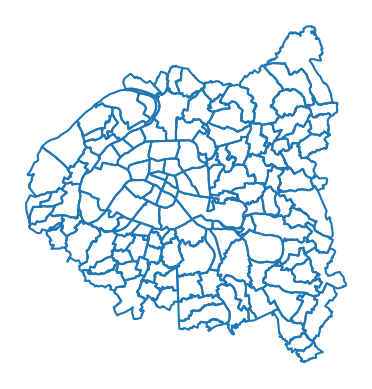

In [22]:
ax = shp_communes.boundary.plot()
ax.set_axis_off()

<div class="alert alert-success" role="alert" style="color: rgba(0,0,0,.8); background-color: white; margin-top: 1em; margin-bottom: 1em; margin:1.5625emauto; padding:0 .6rem .8rem!important;overflow:hidden; page-break-inside:avoid; border-radius:.25rem; box-shadow:0 .2rem .5rem rgba(0,0,0,.05),0 0 .05rem rgba(0,0,0,.1); transition:color .25s,background-color .25s,border-color .25s ; border-right: 1px solid #dee2e6 ; border-top: 1px solid #dee2e6 ; border-bottom: 1px solid #dee2e6 ; border-left:.2rem solid #3fb618;">
<h3 class="alert-heading"><i class="fa fa-pencil"></i> Note</h3>

Si on ne désire pas utiliser le niveau `COMMUNE_ARRONDISSEMENT`,
il est nécessaire de mettre en oeuvre une construction du fond de
carte en plusieurs phases.

En premier lieu, il est nécessaire de récupérer le niveau des communes.

``` python
import cartiflette.s3 as s3

shp_communes = s3.download_vectorfile_url_all(
    crs = 4326,
    values = ["75", "92", "93", "94"],
    borders="COMMUNE",
    vectorfile_format="topojson",
    filter_by="DEPARTEMENT",
    source="EXPRESS-COG-CARTO-TERRITOIRE",
    year=2022)
```

``` python
shp_communes.head(4)
```

<div>
<style scoped>
    .dataframe tbody tr th:only-of-type {
        vertical-align: middle;
    }

    .dataframe tbody tr th {
        vertical-align: top;
    }

    .dataframe thead th {
        text-align: right;
    }
</style>

|     | id                       | ID  | NOM              | NOM_M            | INSEE_COM | STATUT          | POPULATION | INSEE_CAN | INSEE_ARR | INSEE_DEP | INSEE_REG | SIREN_EPCI          | source                           | geometry                                          |
|-----|--------------------------|-----|------------------|------------------|-----------|-----------------|------------|-----------|-----------|-----------|-----------|---------------------|----------------------------------|---------------------------------------------------|
| 0   | COMMUNE_0000000009736048 | NaN | Paris            | PARIS            | 75056     | Capitale d'état | 2165423    | NR        | 1         | 75        | 11        | 200054781           | IGN:EXPRESS-COG-CARTO-TERRITOIRE | POLYGON ((2.36421 48.81640, 2.36333 48.81615, ... |
| 0   | COMMUNE_0000000009736037 | NaN | Levallois-Perret | LEVALLOIS-PERRET | 92044     | Commune simple  | 66082      | 16        | 2         | 92        | 11        | 200054781/200057982 | IGN:EXPRESS-COG-CARTO-TERRITOIRE | POLYGON ((2.28739 48.90364, 2.28846 48.90302, ... |
| 1   | COMMUNE_0000000009736055 | NaN | Bois-Colombes    | BOIS-COLOMBES    | 92009     | Commune simple  | 28841      | 11        | 2         | 92        | 11        | 200054781/200057990 | IGN:EXPRESS-COG-CARTO-TERRITOIRE | POLYGON ((2.26639 48.90629, 2.26645 48.90615, ... |
| 2   | COMMUNE_0000000009736538 | NaN | Malakoff         | MALAKOFF         | 92046     | Commune simple  | 30950      | 18        | 1         | 92        | 11        | 200054781/200057966 | IGN:EXPRESS-COG-CARTO-TERRITOIRE | POLYGON ((2.27818 48.81425, 2.28066 48.81469, ... |

</div>

``` python
ax = shp_communes.boundary.plot()
ax.set_axis_off()
```

![](attachment:03_geopandas_tutorial_files/figure-ipynb/cell-12-output-1.png)

On peut remarquer que la ville de Paris ne comporte pas d’arrondissements
sur cette carte. Pour vous en convaincre, vous pouvez exécuter la
commande :

``` python
ax = shp_communes.loc[shp_communes['INSEE_DEP']=="75"].boundary.plot()
ax.set_axis_off()
```

![](attachment:03_geopandas_tutorial_files/figure-ipynb/cell-13-output-1.png)

Il faut donc utiliser une source complémentaire.
Le contour officiel des arrondissements est
produit par l’IGN séparemment des contours de communes.
Les contours d’arrondissements sont également
disponibles
grâce à `cartiflette`:

``` python
arrondissements = s3.download_vectorfile_url_all(
    crs = 4326,
    values = ["75"],
    borders="COMMUNE_ARRONDISSEMENT",
    vectorfile_format="topojson",
    filter_by="DEPARTEMENT",
    source="EXPRESS-COG-CARTO-TERRITOIRE",
    year=2022)
```

    https://minio.lab.sspcloud.fr/projet-cartiflette/diffusion/shapefiles-test1/year=2022/administrative_level=COMMUNE_ARRONDISSEMENT/crs=4326/DEPARTEMENT=75/vectorfile_format=topojson/provider=IGN/source=EXPRESS-COG-CARTO-TERRITOIRE/raw.topojson

    Downloading: : 0.00iB [00:00, ?iB/s]Downloading: : 8.00kiB [00:00, 51.4kiB/s]Downloading: : 32.0kiB [00:00, 107kiB/s] Downloading: : 40.1kiB [00:00, 123kiB/s]

``` python
ax = arrondissements.boundary.plot(alpha = 0.8, edgecolor = "k")
ax.set_axis_off()
```

![](attachment:03_geopandas_tutorial_files/figure-ipynb/cell-15-output-1.png)

Il ne reste plus qu’à remplacer Paris par
ses arrondissements dans `shp_communes`.
Pour cela, on peut utiliser les méthodes
vues dans le chapitre `Pandas` relatives
aux filtres et à la concaténation
de plusieurs `DataFrames`:

``` python
import pandas as pd

shp_communes = pd.concat(
  [
    shp_communes.loc[shp_communes['INSEE_DEP'] != "75"].to_crs(2154),
    arrondissements.to_crs(2154)
  ])
```

``` python
ax = shp_communes.boundary.plot(alpha = 0.8, edgecolor = "k")
ax.set_axis_off()
```

![](attachment:03_geopandas_tutorial_files/figure-ipynb/cell-17-output-1.png)

Cette approche fonctionne mais elle nécessite un certain nombre
de gestes, qui sont autant de risques d’erreurs. Il est
donc recommandé de privilégier le niveau `COMMUNE_ARRONDISSEMENT`
qui fait exactement ceci mais de manière fiable.

</div>

## Opérations sur les attributs et les géométries

### Import des données vélib

Souvent, le découpage communal ne sert qu’en fond de cartes, pour donner des
repères. En complément de celui-ci, on peut désirer exploiter
un autre jeu de données. On va partir des données de localisation des
stations velib,
disponibles [sur le site d’open data de la ville de Paris](https://opendata.paris.fr/explore/dataset/velib-emplacement-des-stations/table/) et
requêtables directement par l’url
<https://opendata.paris.fr/explore/dataset/velib-emplacement-des-stations/download/?format=geojson&timezone=Europe/Berlin&lang=fr>

In [23]:
velib_data = 'https://opendata.paris.fr/explore/dataset/velib-emplacement-des-stations/download/?format=geojson&timezone=Europe/Berlin&lang=fr'
stations = gpd.read_file(velib_data)
stations.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

Les données sont dans le système de projection WGS84 qui est celui du
système GPS. Celui-ci s’intègre bien avec les fonds de carte
`OpenStreetMap` ou `Google Maps`. En toute rigueur, si on
désire effectuer certains calculs géométriques (mesurer des surfaces…), il est
nécessaire de re-projeter les données dans un système qui préserve la géométrie
(c’est le cas du Lambert 93).

Pour avoir une intuition de la localisation des stations, et notamment de la
densité hétérogène de celles-ci,
on peut afficher les données sur la carte des communes
de la petite couronne. Il s’agit donc d’enrichir la carte
précédente d’une couche supplémentaire, à savoir la localisation
des stations. Au passage, on va utiliser un fond de carte
plus esthétique:

Découvrez ci-dessous par étape les différentes lignes de commandes permettant d’afficher cette carte complète,
étape par étape :

1️⃣ Afficher le nuage de points de 200 stations vélibs prises au hasard

<Axes: >

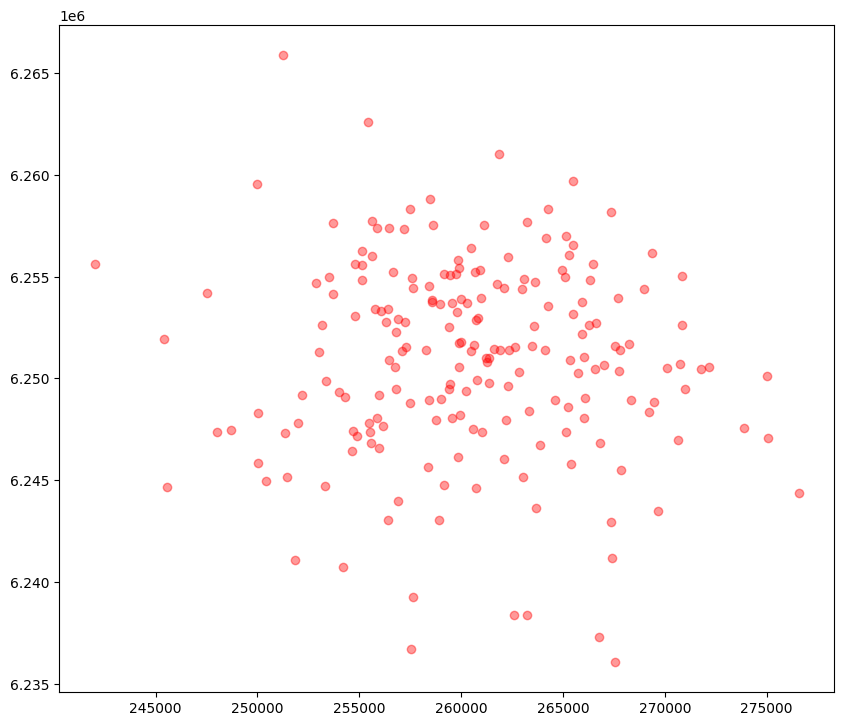

In [27]:
fig, ax = plt.subplots(figsize=(10, 10))

#plot avce geopandas
_ 

2️⃣ Ajouter à cette couche, en-dessous, les contours des communes

<Axes: >

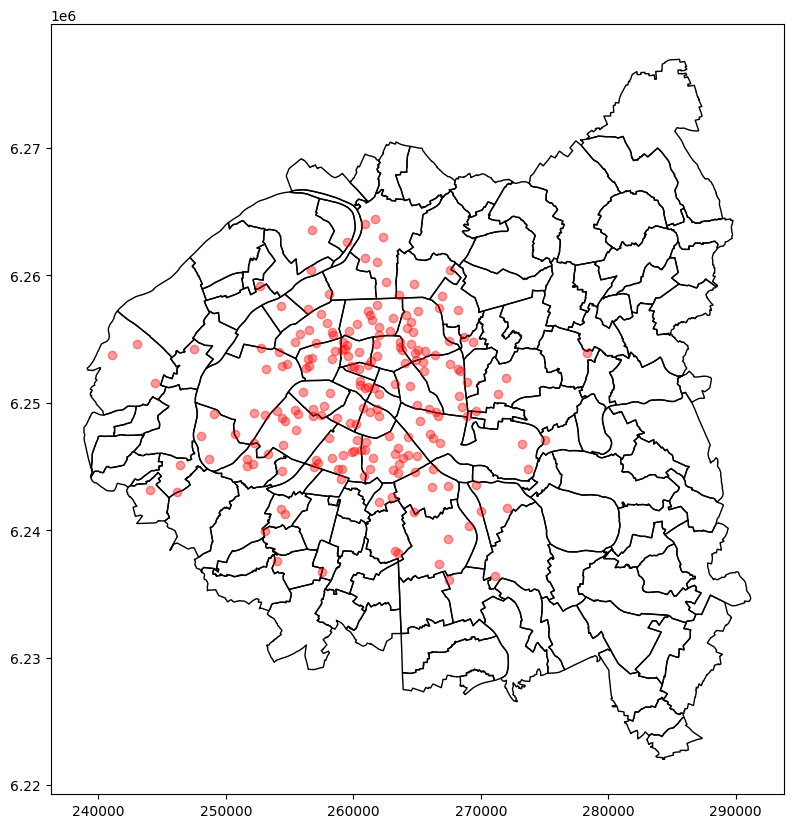

In [11]:
fig, ax = plt.subplots(figsize=(10, 10))

_
_

3️⃣ Ajouter un fond de carte de type *open street map* grâce au package
`contextily`

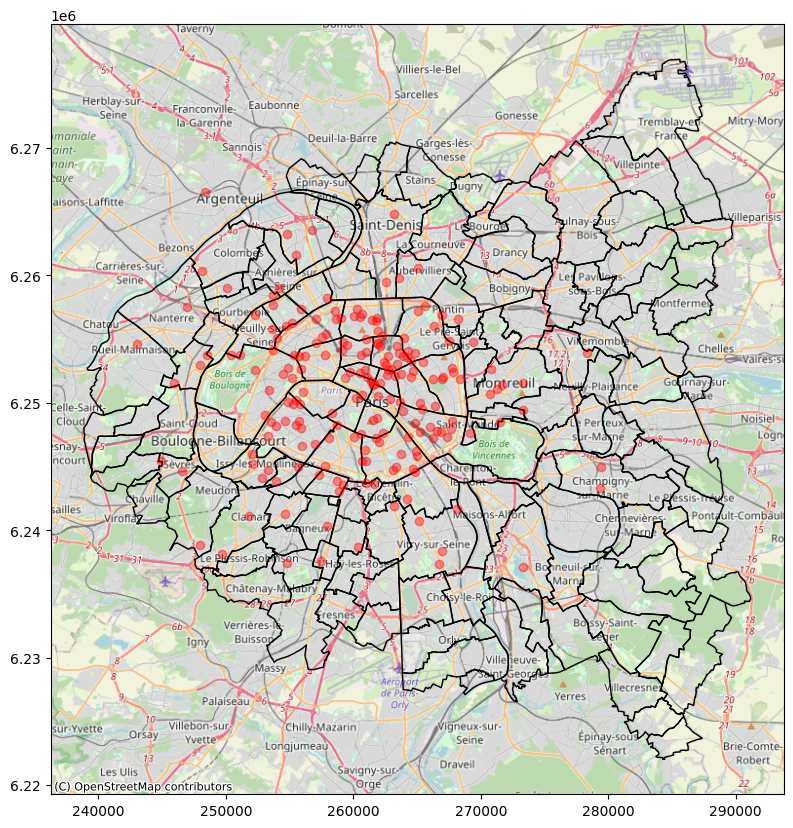

In [12]:
fig,ax = plt.subplots(figsize=(10, 10))

_
_
_


4️⃣
Il ne reste plus qu’à retirer l’axe des coordonnées, qui n’est pas très
esthétique.

<Axes: >

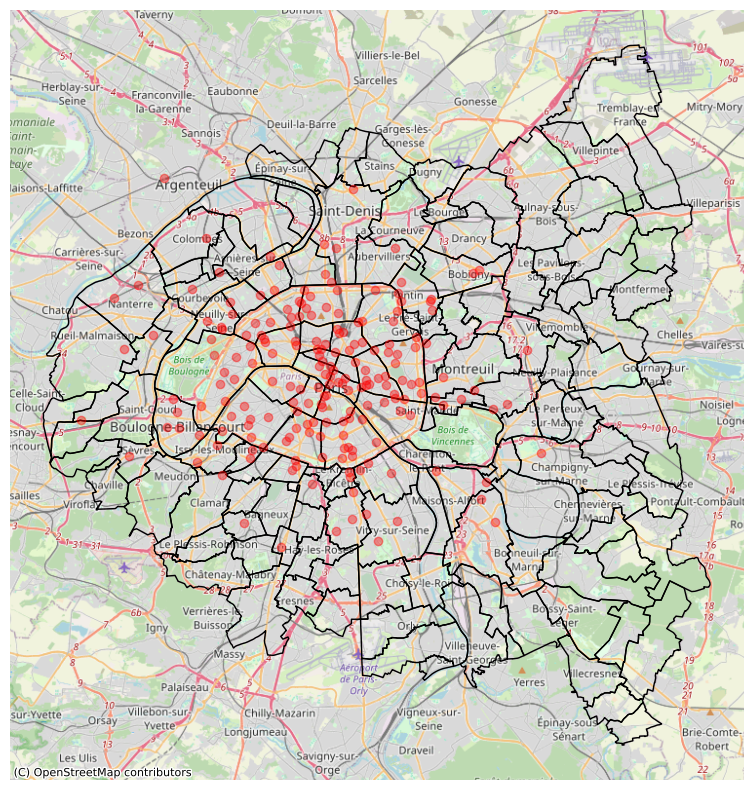

In [13]:
fig,ax = plt.subplots(figsize=(10, 10))
_
_
_
_


### Opérations sur les attributs

Toutes les opérations possibles sur un objet `Pandas` le sont également
sur un objet `GeoPandas`. Pour manipuler les données, et non la géométrie,
on parlera d’opérations sur les attributs.

Par exemple, si on désire
connaître quelques statistiques sur la taille des stations, l’approche
est identique à si on avait un objet `Pandas` classique :

In [14]:
stations.describe()

capacity
count  1486.000000
mean     31.098923
std      12.244767
min       0.000000
25%      23.000000
50%      29.000000
75%      37.000000
max      76.000000

Pour classer les départements de la petite couronne, du plus grand au plus petit,
procédons en deux étapes:



1.  Calculons la surface totale de ce territoire (méthode `area` sur un objet `GeoPandas.GeoDataFrame` ramenée en km², attention néamoins au système de projection comme cela est expliqué plus bas)

In [30]:
shp_communes['surface'] = _

ValueError: Columns must be same length as key

Les plus grands départements s’obtiennent par une agrégation des
surfaces communales :

In [29]:
shp_communes.groupby('INSEE_DEP').sum(numeric_only = True).sort_values('surface', ascending = False)

ID  POPULATION       surface
INSEE_DEP                               
94         0.0     1407124  2.996243e-08
93         0.0     1644903  2.906466e-08
92         0.0     1624357  2.151563e-08
75         0.0     2165423  1.292242e-08

Si on veut directement les plus
grandes communes de la petite couronne parisienne :

In [17]:
shp_communes.sort_values('surface', ascending = False).head(10)

id    ID                       NOM  \
23  COMMUNE_0000000009735015  None        Tremblay-en-France   
12  ARR_MUNI0000000009736553  None  Paris 16e Arrondissement   
19  ARR_MUNI0000000009736532  None  Paris 12e Arrondissement   
7   COMMUNE_0000000009735500  None          Aulnay-sous-Bois   
31  COMMUNE_0000000009736056  None           Rueil-Malmaison   
37  COMMUNE_0000000009736517  None            Noisy-le-Grand   
0   COMMUNE_0000000009735515  None               Saint-Denis   
4   COMMUNE_0000000009736052  None                  Nanterre   
37  COMMUNE_0000000009737009  None           Vitry-sur-Seine   
20  COMMUNE_0000000009735517  None             Gennevilliers   

                       NOM_M INSEE_COM           STATUT  POPULATION INSEE_CAN  \
23        TREMBLAY-EN-FRANCE     93073   Commune simple       36461        20   
12  PARIS 16E ARRONDISSEMENT     75056  Capitale d'état      165523        NR   
19  PARIS 12E ARRONDISSEMENT     75056  Capitale d'état      139297        NR   
7           AULNAY-SOUS-BOIS     93005   Commune simple       86969        02   
31           RUEIL-MALMAISON     92063   Commune simple       78317        22   
37            NOISY-LE-GRAND     93051   Commune simple       67871        14   
0                SAINT-DENIS     93066  Sous-préfecture      112852        99   
4                   NANTERRE     92050       Préfecture       96277        99   
37           VITRY-SUR-SEINE     94081   Commune simple       95510        99   
20             GENNEVILLIERS     92036   Commune simple       48530        14   

   INSEE_ARR INSEE_DEP INSEE_REG           SIREN_EPCI  \
23         2        93        11  200054781/200058097   
12         1        75        11            200054781   
19         1        75        11            200054781   
7          2        93        11  200054781/200058097   
31         2        92        11  200054781/200057982   
37         2        93        11  200054781/200058790   
0          3        93        11  200054781/200057867   
4          2        92        11  200054781/200057982   
37         3        94        11  200054781/200058014   
20         2        92        11  200054781/200057990   

                              source INSEE_COG  \
23  IGN:EXPRESS-COG-CARTO-TERRITOIRE     93073   
12  IGN:EXPRESS-COG-CARTO-TERRITOIRE     75116   
19  IGN:EXPRESS-COG-CARTO-TERRITOIRE     75112   
7   IGN:EXPRESS-COG-CARTO-TERRITOIRE     93005   
31  IGN:EXPRESS-COG-CARTO-TERRITOIRE     92063   
37  IGN:EXPRESS-COG-CARTO-TERRITOIRE     93051   
0   IGN:EXPRESS-COG-CARTO-TERRITOIRE     93066   
4   IGN:EXPRESS-COG-CARTO-TERRITOIRE     92050   
37  IGN:EXPRESS-COG-CARTO-TERRITOIRE     94081   
20  IGN:EXPRESS-COG-CARTO-TERRITOIRE     92036   

                                             geometry       surface  
23  POLYGON ((2.50049 48.97544, 2.50024 48.97561, ...  2.786117e-09  
12  POLYGON ((2.27995 48.87857, 2.28010 48.87852, ...  2.011429e-09  
19  POLYGON ((2.39007 48.82569, 2.38909 48.82635, ...  2.006959e-09  
7   POLYGON ((2.45949 48.95505, 2.45959 48.95527, ...  1.984854e-09  
31  POLYGON ((2.16935 48.89581, 2.16985 48.89553, ...  1.782660e-09  
37  POLYGON ((2.51559 48.85129, 2.51569 48.85133, ...  1.609780e-09  
0   POLYGON ((2.34602 48.94638, 2.34608 48.94641, ...  1.518454e-09  
4   POLYGON ((2.22910 48.90603, 2.23037 48.90377, ...  1.500238e-09  
37  POLYGON ((2.36778 48.77190, 2.36778 48.77204, ...  1.428018e-09  
20  POLYGON ((2.31167 48.94795, 2.31131 48.94695, ...  1.427738e-09

Lors des étapes d’agrégation, `groupby` ne conserve pas les géométries. Autrement
dit, si on effectue, par exemple, une somme en fonction d’une variable de groupe avec
le combo `groupby(...).sum(...)` , on perd
la dimension géographique.

Il est néanmoins possible d’aggréger à la fois les géométries et les
attribus avec la méthode `dissolve`:

<Axes: >

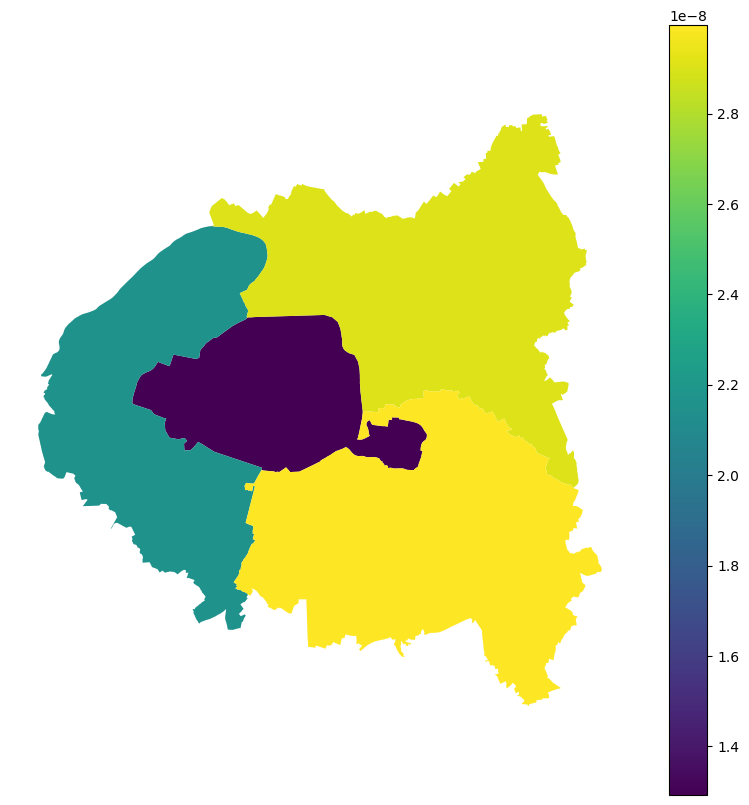

In [39]:
fig,ax = plt.subplots(figsize=(10, 10))

# utiliser dissolve pour aggreger puis afficher les départements selon la surface 
shp_communes.dissolve(by='INSEE_DEP', aggfunc='sum').plot(ax = ax, column = "surface", legend=True)

ax.set_axis_off()
ax

Pour produire l’équivalent de cette carte à un niveau France entière, il est néanmoins plus simple de directement
récupérer les fonds officiels des départements plutôt que d’agréger les
contours des communes:

In [40]:
dep = s3.download_vectorfile_url_all(
    values = "metropole",
    crs = 4326,
    borders = "REGION",
    vectorfile_format="topojson",
    filter_by="FRANCE_ENTIERE",
    source="EXPRESS-COG-CARTO-TERRITOIRE",
    year=2022)

dep["area"] = dep.to_crs(2154).area

https://minio.lab.sspcloud.fr/projet-cartiflette/diffusion/shapefiles-test1/year=2022/administrative_level=REGION/crs=4326/FRANCE_ENTIERE=metropole/vectorfile_format=topojson/provider=IGN/source=EXPRESS-COG-CARTO-TERRITOIRE/raw.topojson


Downloading: : 4.76MiB [00:00, 10.0MiB/s]


Avant de calculer les surfaces des départements, pour éviter les déformations liées au
système `Mercator`, nous faisons une reprojection des données à la volée. Plus de détails
par la suite.

In [33]:
dep.sort_values('area', ascending = False).head(3)

id  ID     NOM_M       NOM INSEE_DEP INSEE_REG  \
33  DEPARTEM_FXX_00000000034 NaN   GIRONDE   Gironde        33        75   
40  DEPARTEM_FXX_00000000041 NaN    LANDES    Landes        40        75   
24  DEPARTEM_FXX_00000000025 NaN  DORDOGNE  Dordogne        24        75   

                              source territoire  \
33  IGN:EXPRESS-COG-CARTO-TERRITOIRE  metropole   
40  IGN:EXPRESS-COG-CARTO-TERRITOIRE  metropole   
24  IGN:EXPRESS-COG-CARTO-TERRITOIRE  metropole   

                                             geometry          area  
33  MULTIPOLYGON (((-1.15275 45.60453, -1.15084 45...  1.036783e+10  
40  POLYGON ((-1.25361 44.46752, -1.25317 44.46762...  9.354177e+09  
24  POLYGON ((-0.04044 45.10261, -0.04073 45.10309...  9.210826e+09

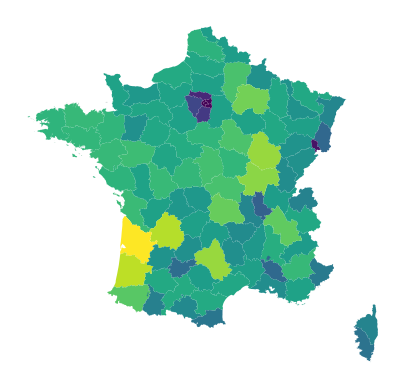

In [34]:
ax = dep.plot(column = "area")
ax.set_axis_off()

### Opérations sur les géométries

Outre la représentation graphique simplifiée,
sur laquelle nous reviendrons ultérieurement, l’intérêt principal d’utiliser
`GeoPandas` est l’existence de méthodes efficaces pour
manipuler la dimension spatiale. Un certain nombre proviennent du
package
[`Shapely`](https://shapely.readthedocs.io/en/latest/manual.html#general-attributes-and-methods).

<div class="alert alert-danger" role="alert" style="color: rgba(0,0,0,.8); background-color: white; margin-top: 1em; margin-bottom: 1em; margin:1.5625emauto; padding:0 .6rem .8rem!important;overflow:hidden; page-break-inside:avoid; border-radius:.25rem; box-shadow:0 .2rem .5rem rgba(0,0,0,.05),0 0 .05rem rgba(0,0,0,.1); transition:color .25s,background-color .25s,border-color .25s ; border-right: 1px solid #dee2e6 ; border-top: 1px solid #dee2e6 ; border-bottom: 1px solid #dee2e6 ; border-left: .2rem solid #ff0039;">
<i class="fa fa-exclamation-triangle"></i> Warning</h3>

Les données sont en système de coordonnées WGS 84 ou pseudo-Mercator (epsg: `4326`) et ne sont pas projetées.
C’est un format approprié lorsqu’il s’agit d’utiliser un fonds
de carte `OpenStreetMap`, `Stamen`, `Google Maps`, etc.

Mais ce n’est pas un
format sur lequel on désire faire des calculs car les distances sont faussées sans utiliser de projection. D’ailleurs, `geopandas` refusera certaines opérations
sur des données dont le crs est `4326`. On reprojette ainsi les données
dans la projection officielle pour la métropole, le Lambert 93
(epsg: `2154`).

</div>

Comme indiqué ci-dessus, nous reprojetons les données
dans le système Lambert 93 qui ne fausse pas les
calculs de distance et d’aires.

In [41]:
communes = shp_communes.to_crs(2154)
stations = stations.to_crs(2154)

Par exemple, on peut recalculer la taille d’une commune ou d’arrondissement
avec la méthode `area` (et diviser par $10^6$ pour avoir des $km^2$ au lieu
des $m^2$):

In [42]:
communes['superficie'] = communes.area.div(10**6)
communes.head(3)

id  ID                      NOM  \
0  ARR_MUNI0000000009736045 NaN  Paris 3e Arrondissement   
1  ARR_MUNI0000000009736046 NaN  Paris 2e Arrondissement   
2  ARR_MUNI0000000009736545 NaN  Paris 4e Arrondissement   

                     NOM_M INSEE_COM           STATUT  POPULATION INSEE_CAN  \
0  PARIS 3E ARRONDISSEMENT     75056  Capitale d'état       34025        NR   
1  PARIS 2E ARRONDISSEMENT     75056  Capitale d'état       21595        NR   
2  PARIS 4E ARRONDISSEMENT     75056  Capitale d'état       29131        NR   

  INSEE_ARR INSEE_DEP INSEE_REG SIREN_EPCI                            source  \
0         1        75        11  200054781  IGN:EXPRESS-COG-CARTO-TERRITOIRE   
1         1        75        11  200054781  IGN:EXPRESS-COG-CARTO-TERRITOIRE   
2         1        75        11  200054781  IGN:EXPRESS-COG-CARTO-TERRITOIRE   

  INSEE_COG                                           geometry       surface  \
0     75103  POLYGON ((652324.622 6862635.302, 652326.463 6...  1.434546e-10   
1     75102  POLYGON ((652167.724 6863604.342, 652193.783 6...  1.216504e-10   
2     75104  POLYGON ((653663.658 6861937.170, 653680.442 6...  1.956241e-10   

   superficie  
0    1.170282  
1    0.992309  
2    1.596122

Une méthode qu’on utilise régulièrement est `centroid` qui, comme son nom l’indique,
recherche le centroïde de chaque polygone et transforme ainsi des données
surfaciques en données ponctuelles. Par exemple, pour
représenter approximativement les centres des villages de la
Haute-Garonne (31), après avoir téléchargé le fonds de carte adapté,
fera

https://minio.lab.sspcloud.fr/projet-cartiflette/diffusion/shapefiles-test1/year=2022/administrative_level=COMMUNE/crs=4326/DEPARTEMENT=31/vectorfile_format=topojson/provider=IGN/source=EXPRESS-COG-CARTO-TERRITOIRE/raw.topojson


Downloading: : 1.60MiB [00:00, 2.07MiB/s]


UnidentifiedImageError: cannot identify image file <_io.BytesIO object at 0x000001E419C23560>

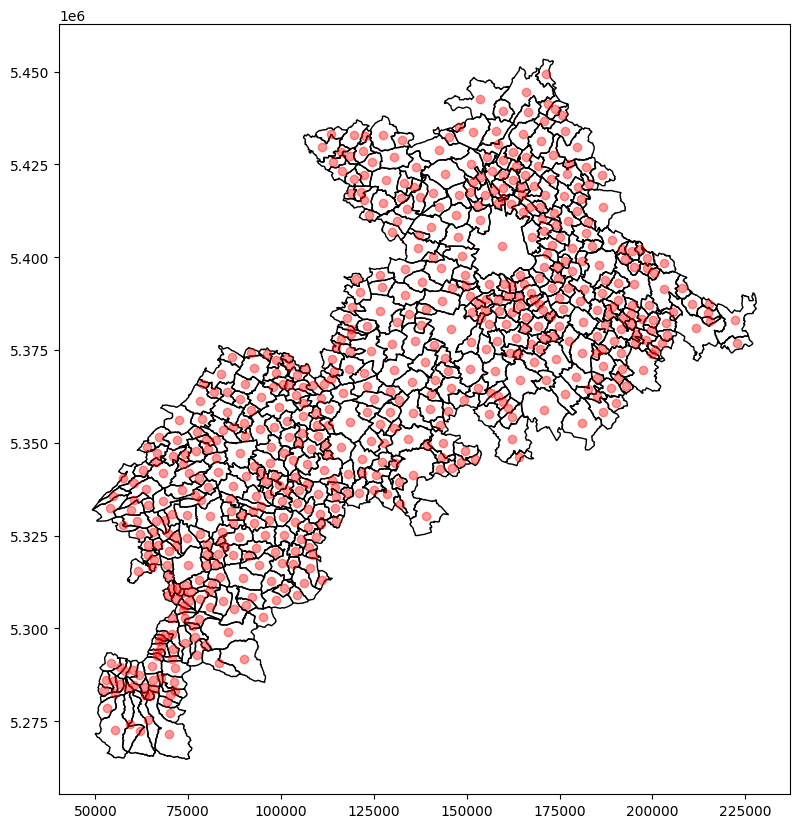

In [44]:
communes_31 = s3.download_vectorfile_url_all(
      crs = 4326,
      values = "31",
      borders="COMMUNE",
      vectorfile_format="topojson",
      filter_by="DEPARTEMENT",
      source="EXPRESS-COG-CARTO-TERRITOIRE",
      year=2022)

# on reprojete en 3857 pour le fond de carte
communes_31 = communes_31.to_crs(3857)

# on calcule le centroide
dep_31 = communes_31.copy()
communes_31['geometry'] = communes_31['geometry'].centroid

# afficher les centroides des communes du 31
ax = _

# afficher les countours des communes avec l'axe partagé avec les centroïdes
__

ctx.add_basemap(ax, source = ctx.providers.OpenStreetMap.Mapnik)

ax.set_axis_off()
ax

## Gérer le système de projection

Précédemment, nous avons appliqué une méthode `to_crs` pour reprojeter
les données dans un système de projection différent de celui du fichier
d’origine :

In [25]:
communes = communes.to_crs(2154)
stations = stations.to_crs(2154)

Concernant la gestion des projections avec `GeoPandas`,
la [documentation officielle](https://geopandas.org/projections.html) est très bien
faite. Elle fournit notamment l’avertissement suivant qu’il est
bon d’avoir en tête :

> Be aware that most of the time you don’t have to set a projection. Data loaded from a reputable source (using the geopandas.read_file() command) should always include projection information. You can see an objects current CRS through the GeoSeries.crs attribute.
>
> From time to time, however, you may get data that does not include a projection. In this situation, you have to set the CRS so geopandas knows how to interpret the coordinates.

![*Image empruntée à XKCD <https://xkcd.com/2256/> qu’on peut également trouver sur <https://blog.chrislansdown.com/2020/01/17/a-great-map-projection-joke/>*](https://imgs.xkcd.com/comics/bad_map_projection_south_america.png)

Pour déterminer le système de projection d’une base de données, on peut vérifier l’attribut `crs` :

In [26]:
communes.crs

<Projected CRS: EPSG:2154>
Name: RGF93 v1 / Lambert-93
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: France - onshore and offshore, mainland and Corsica (France métropolitaine including Corsica).
- bounds: (-9.86, 41.15, 10.38, 51.56)
Coordinate Operation:
- name: Lambert-93
- method: Lambert Conic Conformal (2SP)
Datum: Reseau Geodesique Francais 1993 v1
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

Les deux principales méthodes pour définir le système de projection utilisé sont :

-   **`df.set_crs`** : cette commande sert à préciser quel est le système de projection utilisé, c’est-à-dire comment les coordonnées *(x,y)* sont reliées à la surface terrestre. **Cette commande ne doit pas être utilisée pour transformer le système de coordonnées, seulement pour le définir**.
-   **`df.to_crs`** : **cette commande sert à projeter les points d’une géométrie dans une autre, c’est-à-dire à recalculer les coordonnées selon un autre système de projection.**

Dans le cas particulier de production de carte avec un fond `OpenStreetMaps` ou une carte dynamique `leaflet`, il est nécessaire de dé-projeter les données (par exemple à partir du Lambert-93) pour atterrir dans le système non-projeté WGS 84 (code EPSG 4326). Ce site [dédié aux projections géographiques](https://epsg.io/) peut être utile pour retrouver le système de projection d’un fichier où il n’est pas indiqué.

La définition du système de projection se fait de la manière suivante (:warning: avant de le faire, se souvenir de l’avertissement !) :

``` python
communes = communes.set_crs(2154)
```

Alors que la reprojection (projection Albers : `5070`) s’obtient de la manière suivante :

https://minio.lab.sspcloud.fr/projet-cartiflette/diffusion/shapefiles-test1/year=2022/administrative_level=REGION/crs=4326/FRANCE_ENTIERE=metropole/vectorfile_format=topojson/provider=IGN/source=EXPRESS-COG-CARTO-TERRITOIRE/raw.topojson


Downloading: : 4.76MiB [00:01, 4.59MiB/s]


<Axes: >

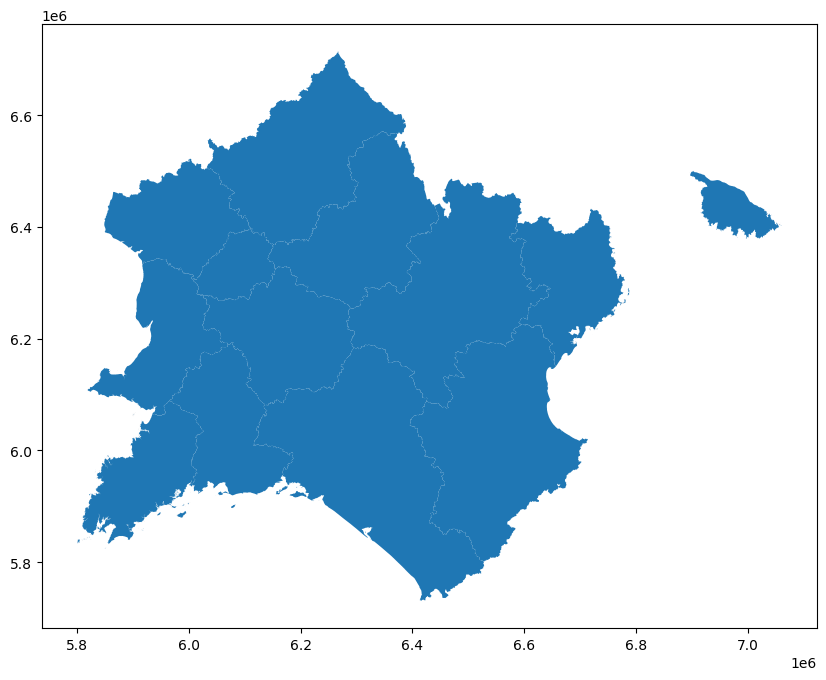

In [27]:
shp_region = s3.download_vectorfile_url_all(
    values = "metropole",
    crs = 4326,
    borders = "REGION",
    vectorfile_format="topojson",
    filter_by="FRANCE_ENTIERE",
    source="EXPRESS-COG-CARTO-TERRITOIRE",
    year=2022)

fig,ax = plt.subplots(figsize=(10, 10))
shp_region.to_crs(5070).plot(ax = ax)
ax

On le voit, cela modifie totalement la représentation de l’objet dans l’espace.
Clairement, cette projection n’est pas adaptée aux longitudes et latitudes françaises.
C’est normal, il s’agit d’une projection adaptée au continent
nord-américain (et encore, pas dans son ensemble !).

C:\Users\Elodie\AppData\Local\Temp\ipykernel_32108\3485617699.py:1: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


<Axes: >

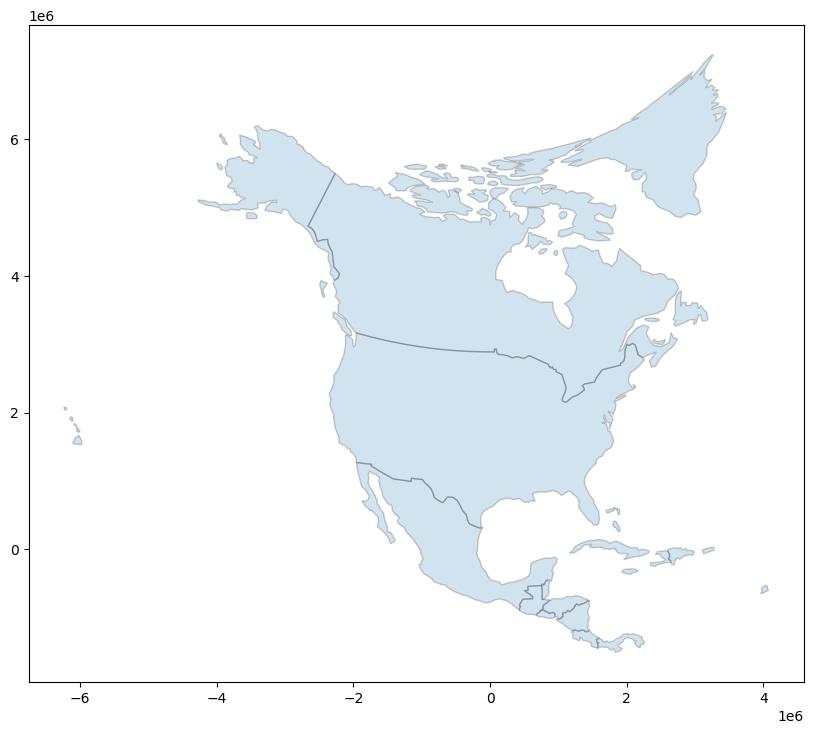

In [45]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

fig,ax = plt.subplots(figsize=(10, 10))
world[world.continent == "North America"].to_crs(5070).plot(alpha = 0.2, edgecolor = "k", ax = ax)
ax